In [ ]:
!pip install tf-nightly

In [ ]:
!unzip '/content/Thai and Indian Currency Dataset256x256.zip'

In [ ]:
PATH = '/content/Thai and Indian Currency Dataset256x256/Thai Currencies'

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
AUTOTUNE = tf.data.experimental.AUTOTUNE

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
import os
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.2)
train_dataset = image_generator.flow_from_directory(str(PATH), target_size=(224, 224), subset='training')
valid_dataset = image_generator.flow_from_directory(str(PATH), target_size=(224, 224), subset='validation')

Found 800 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


In [ ]:
for image_b, label_b in train_dataset:
  print("Image batch shape: ", image_b.shape)
  print("Label batch shape: ", label_b.shape)
  image_batch = image_b
  label_batch = label_b
  print(label_batch)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [ ]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

UnimplementedError: ignored

In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip(input_shape=(224, 224, 3)),                              
  feature_extractor_layer,
  tf.keras.layers.Dense(512),
  tf.keras.layers.Dropout(0.24),
  tf.keras.layers.Dense(train_dataset.num_classes)
])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

EPOCHS = 20
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=EPOCHS)

Epoch 1/20
25/25 [==============================] - 3s 137ms/step - loss: 1.6859 - accuracy: 0.2450 - val_loss: 1.5216 - val_accuracy: 0.3400
Epoch 2/20
25/25 [==============================] - 3s 112ms/step - loss: 1.3269 - accuracy: 0.4675 - val_loss: 1.3485 - val_accuracy: 0.4450
Epoch 3/20
25/25 [==============================] - 3s 113ms/step - loss: 1.0976 - accuracy: 0.6100 - val_loss: 1.2432 - val_accuracy: 0.5050
Epoch 4/20
25/25 [==============================] - 3s 113ms/step - loss: 0.9227 - accuracy: 0.7200 - val_loss: 1.1193 - val_accuracy: 0.5800
Epoch 5/20
25/25 [==============================] - 3s 112ms/step - loss: 0.8254 - accuracy: 0.7550 - val_loss: 1.0589 - val_accuracy: 0.6000
Epoch 6/20
25/25 [==============================] - 3s 113ms/step - loss: 0.7277 - accuracy: 0.8275 - val_loss: 0.9828 - val_accuracy: 0.6700
Epoch 7/20
25/25 [==============================] - 3s 112ms/step - loss: 0.6640 - accuracy: 0.8288 - val_loss: 0.9411 - val_accuracy: 0.6700
Epoch 

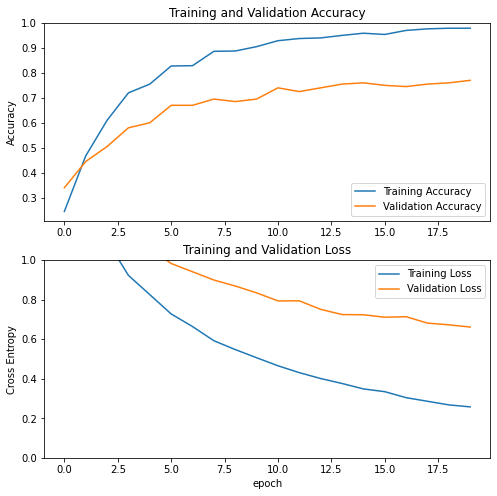

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
feature_extractor_layer.trainable = True

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=0.0001/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 20
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset)

Epoch 20/30
 2/25 [=>............................] - ETA: 8s - loss: 0.7873 - accuracy: 0.7500WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1545s vs `on_train_batch_end` time: 0.2532s). Check your callbacks.


25/25 [==============================] - 11s 431ms/step - loss: 0.8401 - accuracy: 0.7113 - val_loss: 0.6794 - val_accuracy: 0.8200
Epoch 21/30
25/25 [==============================] - 10s 398ms/step - loss: 0.5763 - accuracy: 0.8425 - val_loss: 0.6615 - val_accuracy: 0.8050
Epoch 22/30
25/25 [==============================] - 10s 400ms/step - loss: 0.4510 - accuracy: 0.9013 - val_loss: 0.6178 - val_accuracy: 0.8200
Epoch 23/30
25/25 [==============================] - 10s 398ms/step - loss: 0.3528 - accuracy: 0.9588 - val_loss: 0.5474 - val_accuracy: 0.8500
Epoch 24/30
25/25 [==============================] - 10s 399ms/step - loss: 0.3181 - accuracy: 0.9475 - val_loss: 0.4906 - val_accuracy: 0.8700
Epoch 25/30
25/25 [==============================] - 10s 399ms/step - loss: 0.2428 - accuracy: 0.9762 - val_loss: 0.4429 - val_accuracy: 0.8950
Epoch 26/30
25/25 [==============================] - 10s 398ms/step - loss: 0.2018 - accuracy: 0.9987 - val_loss: 0.4131 - val_accuracy: 0.9050
Epoc